In [1]:
pip install -q yfinance

In [33]:
import torch
import torch.nn as nn
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf

In [34]:
device = ('cuda:0' if torch.cuda.is_available() else "cpu")
device

'cpu'

**Define the LSTM model**

In [35]:

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers= 1,batch_first=True)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers= 1,batch_first=True)
        self.norm2 = nn.LayerNorm(hidden_size)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.norm3 = nn.LayerNorm(hidden_size)

        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.norm1(lstm_out)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.norm2(lstm_out)
        fc1_out = self.fc1(lstm_out[:, -1, :]).squeeze()
        fc1_out = self.norm3(fc1_out)

        fc2_out = self.fc2(fc1_out)

        return fc2_out


*Download the data from yahoo finance*

In [36]:
"""# get amazon data of the past 20 years
df = yf.Ticker('AMZN').history(period='15y')"""
# get Vetoquinol data of the past 10 years
df = yf.Ticker('GOOG').history(period='20y')
company = "Vetoquinol"
#company = "Amazon"
# Get ticker name of the company

# Get Google data of the past 20 years
#df = yf.Ticker('AMZN').history(period='20y')

#df = yf.Ticker('GOOGL').history(period='20y')

Remove unused data, and setup :
- number_of_days : number of days to use to predict the next day
- days_to_predict : number of days to predict
- number_of_features : number of features to use from the data
- number_of_sequences : number of sequences to create from the data
- training length : length of the training data
- testing length : length of the testing data

In [37]:
# prepare data for training : remove Date, Dividend and Stock Splits columns
df.reset_index(inplace=True)
df = df.drop(['Date','Dividends','Stock Splits'],axis=1)
# normalize the data with the biggest value of each column
df = df/df.max()
# create a de normalize function


number_of_days = 40
number_of_features = len(df.columns)
number_of_sequences = len(df)//number_of_days
training_length = int(len(df)*0.7)
testing_length = int(len(df)*0.25)

Create data tensor and output tensor :
- train_data_tensor : tensor of the training data
- train_output_tensor : tensor of the training output
- test_data_tensor : tensor of the testing data
- test_output_tensor : tensor of the testing output

A sliding window is used, the data from day 0 to day number_of_days is used to predict the next day, then the data from day 1 to day number_of_days+1 is used to predict the next day, and so on.

The output tensor is the next days_to_predict days after the data tensor.

The data tensor is a 3D tensor, the first dimension is the number of sequences, the second dimension is the number of days, and the third dimension is the number of features.

The output tensor is a 2D tensor, the first dimension is the number of sequences, and the second dimension is the number of days to predict.

In [38]:
train_data_tensor = torch.tensor([df.iloc[i:i + number_of_days].values for i in range(training_length-number_of_days)]).float().to(device)

train_output_tensor = torch.tensor([df.iloc[i+number_of_days]['Close'] for i in range(training_length-number_of_days)]).float().to(device)

test_data_tensor = torch.tensor([df.iloc[i:i + number_of_days].values for i in range(training_length,training_length+testing_length-number_of_days)]).float().to(device)

test_output_tensor = torch.tensor([df.iloc[i+number_of_days]['Close'] for i in range(training_length,training_length+testing_length-number_of_days)]).float().to(device)

Instantiate the model and train it :
The model has 3 layers :
- LSTM layer with 4 layers
- LSTM layer with 4 layers
- Linear layer with 75 neurons

The ouput of the model is the next days_to_predict days after the data tensor.

In [39]:
# create the model
model = LSTMClassifier(number_of_features,30,1)
model.to(device)

LSTMClassifier(
  (lstm1): LSTM(5, 30, batch_first=True)
  (norm1): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
  (lstm2): LSTM(30, 30, batch_first=True)
  (norm2): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=30, out_features=30, bias=True)
  (norm3): LayerNorm((30,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=30, out_features=1, bias=True)
)

Train the model :
- loss_function : MSE loss function
- optimizer : Adam optimizer

Then, the model is ploted with the loss of the whole training.


epoch:   0 loss: 0.05129502
epoch:   1 loss: 0.01244226
epoch:   2 loss: 0.04008392
epoch:   3 loss: 0.02205558
epoch:   4 loss: 0.00565594
epoch:   5 loss: 0.01163935
epoch:   6 loss: 0.02155216
epoch:   7 loss: 0.01851629
epoch:   8 loss: 0.00902104
epoch:   9 loss: 0.00503055
epoch:  10 loss: 0.00904486
epoch:  11 loss: 0.01368395
epoch:  12 loss: 0.01272329
epoch:  13 loss: 0.00793095
epoch:  14 loss: 0.00484071
epoch:  15 loss: 0.00602998
epoch:  16 loss: 0.00893644
epoch:  17 loss: 0.00961397
epoch:  18 loss: 0.00740757
epoch:  19 loss: 0.00495094
epoch:  20 loss: 0.00467420
epoch:  21 loss: 0.00622054
epoch:  22 loss: 0.00728367
epoch:  23 loss: 0.00652150
epoch:  24 loss: 0.00488658
epoch:  25 loss: 0.00415262
epoch:  26 loss: 0.00479223
epoch:  27 loss: 0.00563221
epoch:  28 loss: 0.00546396
epoch:  29 loss: 0.00446479
epoch:  30 loss: 0.00376419
epoch:  31 loss: 0.00396045
epoch:  32 loss: 0.00447799


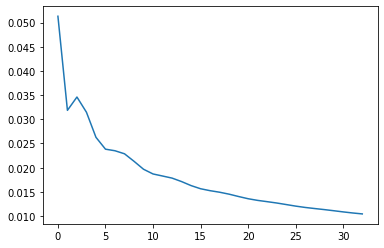

In [48]:
# train the model
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0002)
epochs = 33
compteur = 0
loss_array = []
# reset the weights of the model
for i in range(epochs):
    optimizer.zero_grad()
    y_pred = model(train_data_tensor).reshape(-1)

    single_loss = loss_function(y_pred,train_output_tensor)
    loss_array.append(single_loss.item())


    single_loss.backward()

    optimizer.step()
    print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')
    # plot the loss of the whole training

    if compteur == len(train_data_tensor)-1:
        compteur = 0
    else:
        compteur += 1
# plot the loss of the whole training with loss_array
#reset plt to plot the loss
plt.clf()

loss_array_smoothed = pd.Series(loss_array).ewm(span=1000).mean()
plt.plot(loss_array_smoothed)
plt.show()



Test the model on the testing data :


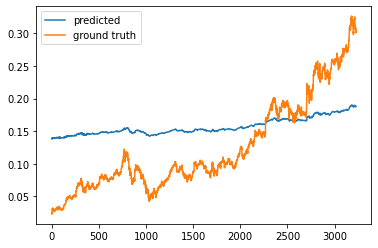

In [50]:

# test the model on the training data
predicted_training = []
y_values_as_list = []




y_pred = model(train_data_tensor)
train_results = y_pred.detach()

y_pred = y_pred.cpu()
# plot with matplotlib expected vs predicted, the x axis is the years

#train_data['Close'].plot()
# plot the predicted values as point
# remove even index
# put data every number_of_days, and 0 elsewhere to plot the points
#divide by 2 x axis to plot the points
plt.plot(y_pred.detach().cpu(),label='predicted')
plt.plot(train_output_tensor.cpu(),label='ground truth')

plt.legend()




plt.show()

Test the model on the testing data :

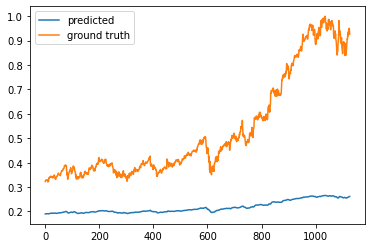

In [51]:

# test the model on the training data


y_pred = model(test_data_tensor)


test_results = y_pred.detach()

plt.plot(y_pred.detach().cpu(),label='predicted')
plt.plot(test_output_tensor.cpu(),label='ground truth')

plt.legend()



plt.show()